In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from scipy import interp

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

Using TensorFlow backend.


# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention with missings values > -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()

####### Nominal #######
all_data = pd.concat([all_data,
                                pd.get_dummies(all_data['SHIPPING_MODE'], prefix='SHIPPING_MODE'),
                                pd.get_dummies(all_data['SELLER_COUNTRY'], prefix='SELLER_COUNTRY'),
                                pd.get_dummies(all_data['PRODUCT_TYPE'], prefix='PRODUCT_TYPE'),
                                pd.get_dummies(all_data['PRODUCT_FAMILY'], prefix='PRODUCT_FAMILY'),
                                pd.get_dummies(all_data['BUYER_DEPARTMENT'], prefix='BUYER_DEPARTMENT'),
                                pd.get_dummies(all_data['SELLER_DEPARTMENT'], prefix='SELLER_DEPARTMENT')
                           ],
                          axis=1)

#######Ordinal #######
all_data['PRICECLUB_STATUS'] = all_data['PRICECLUB_STATUS'].map( {'MISSING':0,'UNSUBSCRIBED':1, 'REGULAR': 2, 'SILVER':3, 'GOLD':4, 'PLATINUM':5}).astype(np.int16)
all_data['SHIPPING_PRICE'] = all_data['SHIPPING_PRICE'].map( {'MISSING':0,'<1':1, '1<5': 2, '5<10':3, '10<20':4, '>20':5}).astype(np.int16)
all_data['WARRANTIES_PRICE'] = all_data['WARRANTIES_PRICE'].map( {'NON_WARRANTIES':0, '<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5}).astype(np.int16)
all_data['PURCHASE_COUNT'] = all_data['PURCHASE_COUNT'].map( {'<5':1, '5<20': 2, '20<50':3, '50<100':4, '100<500':5, '>500':6}).astype(np.int16)
all_data['SELLER_SCORE_COUNT'] = all_data['SELLER_SCORE_COUNT'].map( {'MISSING':0,'<100':1, '100<1000': 2, '1000<10000':3, '10000<100000':4, '100000<1000000':5}).astype(np.int16)
all_data['ITEM_PRICE'] = all_data['ITEM_PRICE'].map( {'<10':0, '10<20': 1, '20<50':2, '50<100':3, '100<500':4, '500<1000':5, '1000<5000':6, '>5000':7}).astype(np.int16)

# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)
all_data = all_data.drop(['WARRANTIES_FLG'],  axis=1)

# REMOVAL OF FEATURES THAT WERE ENCODED
all_data = all_data.drop(['SHIPPING_MODE'],  axis=1)
all_data = all_data.drop(['SELLER_COUNTRY'],  axis=1)
all_data = all_data.drop(['PRODUCT_FAMILY'],  axis=1)
all_data = all_data.drop(['PRODUCT_TYPE'],  axis=1)
all_data = all_data.drop(['BUYER_DEPARTMENT'],  axis=1)
all_data = all_data.drop(['SELLER_DEPARTMENT'],  axis=1)

# Machine Learning

In [9]:
def plot_roc_curve(y, y_predicted, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
   
    #################################### Calcul of ROC by class ####################################
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #################################### Calcul of ROC micro ####################################
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #################################### Calcul of ROC macro ####################################
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) # First aggregate all false positive rates

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes # Finally average it and compute AUC

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    ################################### Plot  ###################################
    l1='micro-average (area = {0:0.2f})'.format(roc_auc["micro"])
    l2='macro-average (area = {0:0.2f})'.format(roc_auc["macro"])

    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"], label=l1, color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label=l2, color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],  lw=2, label='{0} (area = {1:0.2f})'.format(target_vectoriser(i), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [10]:
numerical, categorical=list(), list()
for x in all_data.columns : 
    if x  in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE', 'PRICECLUB_STATUS', 'SHIPPING_PRICE', 'WARRANTIES_PRICE', 'PURCHASE_COUNT', 'SELLER_SCORE_COUNT', 'ITEM_PRICE'] :
        numerical.append(all_data.columns.get_loc(x))
    else :
        categorical.append(all_data.columns.get_loc(x))
        
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:,self.columns]

def create_network(nfeatures, nhiddenUnits):
    model = Sequential()
    model.add(Dense(nhiddenUnits, input_dim=nfeatures, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #stochastic gradient descent
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


In [11]:
def run_gridSearchCV(scaler):
    
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    imputer = Imputer(strategy='mean', missing_values=-1) 
    nfeatures=all_data.shape[1]
    
    cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=0)
    classifier = KerasClassifier(build_fn=create_network, nfeatures=nfeatures, nhiddenUnits=295) 
    
    pNumerical = make_pipeline(ColumnSelector(columns=numerical), scaler)
    pCategorical = make_pipeline(ColumnSelector(columns=categorical))
    pNumericalCategorical=FeatureUnion(n_jobs =1, transformer_list=[('1',pNumerical),('2',pCategorical)])
    pipeline = Pipeline((('imp', imputer), ('pls', pNumericalCategorical), ('clf', classifier)))
    
    params = {
        'clf__epochs': np.linspace(10,50,21, dtype=int)
    }
    gs = GridSearchCV(pipeline, params, cv=cv, n_jobs=1, scoring='f1_weighted', return_train_score =True)
    gs.fit(X_train, y_train, **{'clf__sample_weight': w, 'clf__batch_size':10, 'clf__verbose':0})

    cv_results = pd.DataFrame(gs.cv_results_)[['param_clf__epochs', 'mean_test_score', 'std_test_score']]
    cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
    print(gs.best_params_)

    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(cv_results['param_clf__epochs'],cv_results['mean_test_score'],'-o')
    plt.subplot(2,1,2)
    plt.plot(cv_results['param_clf__epochs'],cv_results['std_test_score'],'-o')
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
{'clf__epochs': 38}


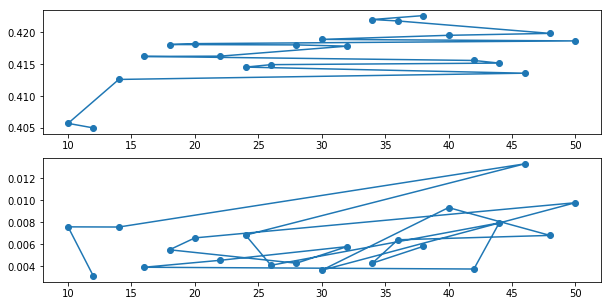

Wall time: 7h 44min 26s


In [12]:
%%time
run_gridSearchCV(StandardScaler())

In [ ]:
%%time
run_gridSearchCV(MinMaxScaler())

In [ ]:
%%time
run_gridSearchCV(RobustScaler())

In [ ]:
%%time
run_gridSearchCV(Normalizer())

In [12]:
def run_classifier(_epochs, scaler):
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    imputer = Imputer(strategy='mean', missing_values=-1) 
    nfeatures=all_data.shape[1]

    classifier = KerasClassifier(build_fn=create_network, nfeatures=nfeatures, nhiddenUnits=295)
    pNumerical = make_pipeline(ColumnSelector(columns=numerical), scaler)
    pCategorical = make_pipeline(ColumnSelector(columns=categorical))
    pNumericalCategorical=FeatureUnion([('1',pNumerical),('2',pCategorical)])
    pipeline = Pipeline((('imp', imputer), ('pls', pNumericalCategorical), ('clf', classifier)))

    pipeline.fit(X_train, y_train, **{'clf__sample_weight': w, 'clf__epochs': _epochs, 'clf__batch_size':10, 'clf__verbose':0})
    y_test_predicted = pipeline.predict(X_test)
    y_test_predicted_label = target_vectoriser(y_test_predicted)
    y_test_label = target_vectoriser(y_test)
    print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), lb.fit_transform(y_test_predicted), average='weighted'), '\n')
    print(classification_report(y_test_label, y_test_predicted_label))

In [19]:
%%time
run_classifier(38, StandardScaler())

f1_score:       0.4066408652855634 
roc_auc_score:  0.6560325260667542 

                          precision    recall  f1-score   support

                       -       0.60      0.82      0.69      3059
                 DAMAGED       0.23      0.27      0.25      1159
               DIFFERENT       0.16      0.33      0.21       836
                    FAKE       0.04      0.25      0.06        24
            NOT_RECEIVED       0.57      0.30      0.40      2831
SELLER_CANCEL_POSTERIORI       0.57      0.25      0.34      2698
               UNDEFINED       0.22      0.27      0.24       790
              WITHDRAWAL       0.25      0.30      0.27      1365

             avg / total       0.46      0.41      0.41     12762

Wall time: 8min 38s


In [13]:
%%time
run_classifier(38, MinMaxScaler())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
f1_score:       0.4211887538667297 
roc_auc_score:  0.6615232785477804 

                          precision    recall  f1-score   support

                       -       0.59      0.83      0.69      3059
                 DAMAGED       0.24      0.24      0.24      1159
               DIFFERENT       0.16      0.26      0.20       836
                    FAKE       0.04      0.21      0.07        24
            NOT_RECEIVED       0.53      0.38      0.44      2831
SELLER_CANCEL_POSTERIORI       0.53      0.29      0.38      2698
               UNDEFINED       0.22      0.25      0.24       790
              WITHDRAWAL       0.27      0.27      0.27      1365

             avg / total       0.45      0.43      0.42     12762

Wall time: 8min 28s


In [14]:
%%time
run_classifier(38, RobustScaler())

f1_score:       0.4166302534523425 
roc_auc_score:  0.6594210130869387 

                          precision    recall  f1-score   support

                       -       0.61      0.79      0.69      3059
                 DAMAGED       0.23      0.40      0.29      1159
               DIFFERENT       0.17      0.22      0.19       836
                    FAKE       0.07      0.21      0.11        24
            NOT_RECEIVED       0.55      0.32      0.41      2831
SELLER_CANCEL_POSTERIORI       0.55      0.29      0.38      2698
               UNDEFINED       0.20      0.28      0.23       790
              WITHDRAWAL       0.25      0.26      0.26      1365

             avg / total       0.46      0.42      0.42     12762

Wall time: 8min 26s


In [15]:
%%time
run_classifier(38, Normalizer())

f1_score:       0.3558542439560549 
roc_auc_score:  0.6197787932977274 

                          precision    recall  f1-score   support

                       -       0.52      0.61      0.56      3059
                 DAMAGED       0.19      0.26      0.22      1159
               DIFFERENT       0.16      0.16      0.16       836
                    FAKE       0.02      0.21      0.04        24
            NOT_RECEIVED       0.49      0.29      0.36      2831
SELLER_CANCEL_POSTERIORI       0.49      0.25      0.33      2698
               UNDEFINED       0.17      0.37      0.23       790
              WITHDRAWAL       0.23      0.27      0.25      1365

             avg / total       0.40      0.35      0.36     12762

Wall time: 8min 35s


In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
w=compute_sample_weight(class_weight='balanced', y=y_train) 
imputer = Imputer(strategy='mean', missing_values=-1)
nfeatures=all_data.shape[1]

imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler=RobustScaler()
X_train_transformed = X_train_imputed
X_train_transformed[:,numerical] = scaler.fit_transform(X_train_imputed[:,numerical])
X_test_transformed = X_test
X_test_transformed[:,numerical] = scaler.transform(X_test_imputed[:,numerical])

classifier = KerasClassifier(build_fn=create_network, nfeatures=nfeatures, nhiddenUnits=295)
classifier.fit(X_train_transformed, y_train, sample_weight=w, epochs=38, batch_size=10, verbose=0)
y_test_predicted = classifier.predict(X_test_transformed)
y_test_predicted_label = target_vectoriser(y_test_predicted)
y_test_label = target_vectoriser(y_test)
y_test_binary = lb.fit_transform(y_test)
print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), lb.fit_transform(y_test_predicted), average='weighted'), '\n')
print(classification_report(y_test_label, y_test_predicted_label))

f1_score:       0.41033594766520826 
roc_auc_score:  0.6554518572639764 

                          precision    recall  f1-score   support

                       -       0.61      0.78      0.68      3059
                 DAMAGED       0.22      0.31      0.25      1159
               DIFFERENT       0.15      0.25      0.19       836
                    FAKE       0.06      0.25      0.10        24
            NOT_RECEIVED       0.60      0.27      0.37      2831
SELLER_CANCEL_POSTERIORI       0.50      0.35      0.42      2698
               UNDEFINED       0.19      0.33      0.24       790
              WITHDRAWAL       0.28      0.21      0.24      1365

             avg / total       0.45      0.41      0.41     12762



In [17]:
matrix=pd.crosstab(y_test_label, y_test_predicted_label, rownames=['Current'], colnames=['Predicted'])
matrix['Total']= matrix.sum(axis=1)
matrix.loc["Total"]=matrix.sum()
matrix

Predicted,-,DAMAGED,DIFFERENT,FAKE,NOT_RECEIVED,SELLER_CANCEL_POSTERIORI,UNDEFINED,WITHDRAWAL,Total
Current,,,,,,,,,
-,2386,64,122,4,69,209,115,90,3059
DAMAGED,123,359,195,13,87,95,198,89,1159
DIFFERENT,143,170,213,8,70,98,69,65,836
FAKE,2,7,4,6,2,1,1,1,24
NOT_RECEIVED,457,467,341,26,769,274,328,169,2831
SELLER_CANCEL_POSTERIORI,520,266,338,16,135,955,217,251,2698
UNDEFINED,90,129,86,5,68,69,259,84,790
WITHDRAWAL,209,196,158,18,92,192,210,290,1365
Total,3930,1658,1457,96,1292,1893,1397,1039,12762
